In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [3]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
parkinsons = fetch_ucirepo(id=174) 
  
# data (as pandas dataframes) 
X = parkinsons.data.features 
y = parkinsons.data.targets 
  
# metadata 
print(parkinsons.metadata) 
  
# variable information 
print(parkinsons.variables) 


{'uci_id': 174, 'name': 'Parkinsons', 'repository_url': 'https://archive.ics.uci.edu/dataset/174/parkinsons', 'data_url': 'https://archive.ics.uci.edu/static/public/174/data.csv', 'abstract': "Oxford Parkinson's Disease Detection Dataset", 'area': 'Health and Medicine', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 197, 'num_features': 22, 'feature_types': ['Real'], 'demographics': [], 'target_col': ['status'], 'index_col': ['name'], 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2007, 'last_updated': 'Wed Feb 14 2024', 'dataset_doi': '10.24432/C59C74', 'creators': ['Max Little'], 'intro_paper': {'ID': 385, 'type': 'NATIVE', 'title': 'Exploiting Nonlinear Recurrence and Fractal Scaling Properties for Voice Disorder Detection', 'authors': 'Max A. Little, P. McSharry, S. Roberts, D. Costello, I. Moroz', 'venue': 'BioMedical Engineering OnLine', 'year': 2007, 'journal': None, 'DOI': '10.1186/1475-925X-6-23', 'URL

In [4]:
path = "https://archive.ics.uci.edu/static/public/174/data.csv"
df = pd.read_csv(path)
df.head(200)

,name,MDVP:Fo,MDVP:Fhi,MDVP:Flo,MDVP:Jitter,MDVP:Jitter.1,MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,...,Shimmer:DDA,NHR,HNR,status,RPDE,DFA,spread1,spread2,D2,PPE
0,phon_R01_S01_1,119.992,157.302,74.997,0.00784,0.00007,0.00370,0.00554,0.01109,0.04374,...,0.06545,0.02211,21.033,1,0.414783,0.815285,-4.813031,0.266482,2.301442,0.284654
1,phon_R01_S01_2,122.400,148.650,113.819,0.00968,0.00008,0.00465,0.00696,0.01394,0.06134,...,0.09403,0.01929,19.085,1,0.458359,0.819521,-4.075192,0.335590,2.486855,0.368674
2,phon_R01_S01_3,116.682,131.111,111.555,0.01050,0.00009,0.00544,0.00781,0.01633,0.05233,...,0.08270,0.01309,20.651,1,0.429895,0.825288,-4.443179,0.311173,2.342259,0.332634
3,phon_R01_S01_4,116.676,137.871,111.366,0.00997,0.00009,0.00502,0.00698,0.01505,0.05492,...,0.08771,0.01353,20.644,1,0.434969,0.819235,-4.117501,0.334147,2.405554,0.368975
4,phon_R01_S01_5,116.014,141.781,110.655,0.01284,0.00011,0.00655,0.00908,0.01966,0.06425,...,0.10470,0.01767,19.649,1,0.417356,0.823484,-3.747787,0.234513,2.332180,0.410335
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
190,phon_R01_S50_2,174.188,230.978,94.261,0.00459,0.00003,0.00263,0.00259,0.00790,0.04087,...,0.07008,0.02764,19.517,0,0.448439,0.657899,-6.538586,0.121952,2.657476,0.133050
191,phon_R01_S50_3,209.516,253.017,89.488,0.00564,0.00003,0.00331,0.00292,0.00994,0.02751,...,0.04812,0.01810,19.147,0,0.431674,0.683244,-6.195325,0.129303,2.784312,0.168895
192,phon_R01_S50_4,174.688,240.005,74.287,0.01360,0.00008,0.00624,0.00564,0.01873,0.02308,...,0.03804,0.10715,17.883,0,0.407567,0.655683,-6.787197,0.158453,2.679772,0.131728
193,phon_R01_S50_5,198.764,396.961,74.904,0.00740,0.00004,0.00370,0.00390,0.01109,0.02296,...,0.03794,0.07223,19.020,0,0.451221,0.643956,-6.744577,0.207454,2.138608,0.123306


After loading and seeing the dataset, the first thing to notice are the differences between values of **PD** (at the top of the dataset) and of **normal people** (at the end of the dataset):

    1) *Average vocal fundamental frequency* (MDVP:Fo) and *Maximum vocal fundamental f* (MDVP:Fhi) are much higher in normal people cause PD have difficulties into speech (more difficulties for laringeal muscles)

    2) *Minimum vocal fundamental frequency* (MDVP:Flo) is lower in normal than in PD. This is quite variable and often in literature we see the opposite, the key thing is that there is a difference with normal.

    3) Different measures of *variation in fundamental frequency* (MDVP:Jitter, Shimmer) are higher for PD than normal cause they can't keep a clean and costant neural potential like normal. 

The other features of the dataset are similar measurement and correlate with the ones just seen. We'll proceed with data exploration

In [5]:
print(f"Dataset shape: {df.shape}")
print(f"Dataset size: {df.size}")

print(df['status'].value_counts())

Dataset shape: (195, 24)
Dataset size: 4680
status
1    147
0     48
Name: count, dtype: int64


In [6]:
df.isnull().sum()

name              0
MDVP:Fo           0
MDVP:Fhi          0
MDVP:Flo          0
MDVP:Jitter       0
MDVP:Jitter.1     0
MDVP:RAP          0
MDVP:PPQ          0
Jitter:DDP        0
MDVP:Shimmer      0
MDVP:Shimmer.1    0
Shimmer:APQ3      0
Shimmer:APQ5      0
MDVP:APQ          0
Shimmer:DDA       0
NHR               0
HNR               0
status            0
RPDE              0
DFA               0
spread1           0
spread2           0
D2                0
PPE               0
dtype: int64

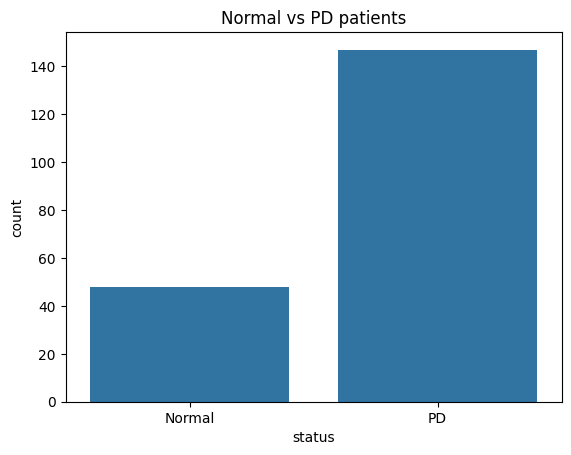

In [ ]:
sns.countplot(data=df, x=df['status'])
plt.title("Normal vs PD patients")
plt.xticks(ticks=[0,1], labels=["Normal", "PD"])
plt.show()

<Axes: >

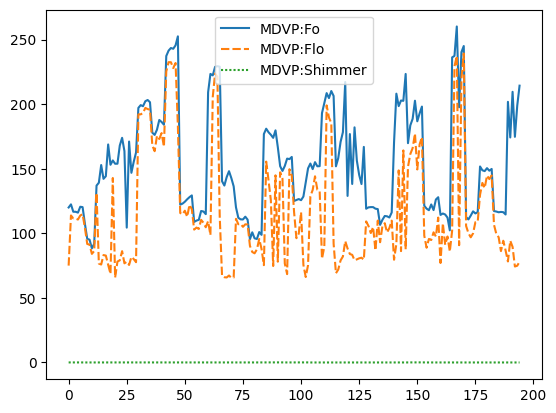

In [ ]:
#create a plot with 3 features as a line of a specific color and 
#on x the records of every patient and on y the value

sns.lineplot(data=df.filter(items=["MDVP:Fo", "MDVP:Flo", "MDVP:Shimmer"]))
#this doesn't look good, i expected two very different groups for every feature